# Integración Númerica

In [7]:
%load_ext autoreload
%autoreload 1
%aimport numa_teaching.formatting
from numa_teaching.formatting import fltx, nan_sp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# sympy
from sympy import init_printing
from sympy import I, nroots, lambdify, diff, latex, symbols, pi, interpolating_poly, cos, N, integrate, Integral, exp, solve
from sympy.abc import x, epsilon, alpha
import operator
import functools
init_printing()
#init_printing(use_latex=False)

In [9]:
# numpy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 9] # ancho, alto de figuras
plt.rcParams["font.size"] = 20

In [38]:
# Jupyter/ IPython formatting
from IPython.display import Math, Latex

In [12]:
from collections import namedtuple
from itertools import zip_longest

Latex macros
$$ 
\newcommand{\d}{\mathrm{d}}
\DeclareMathOperator{\deg}{deg}
$$

## Integración

Como evaluamos
$$
I = \int_a^b f(x) \,\d x
$$
Con $F(x)$ la anti-derivada de $f(x)$ podemos usar
$$
I = \int_a^b f(x) \,\d x = F(x)\bigr|_a^b = F(b) - F(a)
$$
En la practica, no siempre es posible encontrar la anti-derivada. E incluso en estos casos puede ser más eficiente usar una metodo numérico para la evaluación del integral

### Un integral complicado

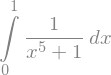

In [13]:
f1 = 1/(1 + x**5)
I1 = Integral(f1, (x, 0, 1)); I1

La antiderivada de 
{{Math("{}".format(latex(f1)))}}
tiene una forma complicada y no es fácil encontrarla a mano

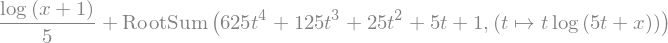

In [14]:
integrate(f1, x)

In [15]:
I1_e = integrate(f1, (x, 0, 1)).evalf()

In [16]:
init_printing(use_latex=False)

El valor númerico de la integral es 
{{Math("{} = {}".format(latex(I1), fltx(float(I1_e), 15, raw=True)) )}}

In [17]:
from scipy.integrate import quad
f1n = lambdify(x, f1)
I1_n, I1_err = quad(f1n, 0, 1)

Con evaluación numérica obtenemos
{{Math("{} = {}".format(latex(I1), fltx(I1_n, 15, raw=True)))}}
con un error estimado de {{fltx(I1_err)}}.

In [18]:
# Tiempo de evaluación
%timeit -n1 -r1 integrate(f1, (x, 0, 1)).evalf()
%timeit -n1 -r1 quad(f1n, 0, 1)
%timeit -n1000 -r1 quad(f1n, 0, 1)

1.25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
28.4 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
12.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)


## Marco generál para integración numérica

Utilizamos la mísma idea que antes: buscamos un problema que podemos resolver, que es cerca al problema original. Para evaluar
$$
I = \int_a^b f(x) \,\d x
$$
buscamos una función $\tilde f(x)$ que aproxima $f(x)$. Ahora evaluamos
$$
I \approx \int_a^b \tilde f(x) \,\d x \equiv \tilde I
$$

### Error de la aproximación

\begin{align}
E   &= I - \tilde I = \int_a^b \bigl[ f(x) - \tilde f(x) \bigr]\, \d x\\
|E| &\leq \int_a^b \bigl| f(x) - \tilde f(x) \bigr|\, \d x\\
    &\leq (b-a) \bigl|\bigl| f - \tilde f \bigr|\bigr|_\infty\\
\bigl|\bigl| f - \tilde f \bigr|\bigr|_\infty &\equiv \max_{a \leq x \leq b} \bigl| f - \tilde f \bigr| \\  
\end{align}

### Posibles aproximaciones

Nos interesan aproximantes $\tilde f(x)$ que se puenden integrar *faxilmente y en forma cerada*. Ejemplos son *polinomios*, *funciones trigonmetricos*, *polinomios por partes*.

Para aproximaciones por polinomios tenemos las posibilidades

1. *Polinomios de Taylor* para $f(x)$
2. *Polinomios interpolantes* para $f(x)$

### Ejemplo

$$
I = \int_0^1 e^{x^2}\, \d x
$$
Utilizamos
\begin{align}
e^t &=  1 + t + \frac{1}{2!} t^2 + \dots + \frac{1}{n!} t^n + \frac{1}{(n+1)!} t^{n+1} e^{c_t} \\
e^{x^2} &=  1 + x^2 + \frac{1}{2!} x^4 + \dots + \frac{1}{n!} x^{2n} + \frac{1}{(n+1)!} x^{2n+2} e^{d_x} \\
\end{align}
con $0 \leq d_x \leq x^2$. Obtenemos ahora
\begin{multline}
I = \int_0^1 \bigl[ 1 + x^2 + \frac{1}{2!} x^4 + \dots + \frac{1}{n!} x^{2} \bigr] \,\d x \\
+ \frac{1}{(n + 1)!} \int_0^1 \bigl[ x^{2n+2} e^{d_x} \bigr] \,\d x\\
\end{multline}


\begin{multline}
I = \int_0^1 \bigl[ 1 + x^2 + \frac{1}{2!} x^4 + \dots + \frac{1}{n!} x^{2} \bigr] \,\d x \\
+ \frac{1}{(n + 1)!} \int_0^1 \bigl[ x^{2n+2} e^{d_x} \bigr] \,\d x\\
\end{multline}

Para $n = 3$ obtenemos
\begin{align}
I &= 1 + \frac{1}{3} + \frac{1}{10} + \frac{1}{42} + E = 1.4571 + E\\
0 < E &\leq \frac{e}{24} \int_0^1 x^8\,\d x = \frac{e}{216} = 0.0126
\end{align}


## Integración usando polinomios interpolantes

En general es más difícil construir metodos para la integración numérica a partir de polinomios de Taylor que es usando polinomios interpolantes. Entonces vamos a construir nuestro $\tilde f$ en 
$$
\int_a^b f(x)\,\d x \approx \int_a^b \tilde f(x)\,\d x
$$
utilizando interpolación.

Inicialmente trabajamos on nodos equidistantes en la construcción de los metodos de interpolación.

## Interpolación lineal

La interpolante lineal para $f(x)$, interpolando entre $a$ y $b$, es
$$
P_1(x) = \frac{(b-x) f(x) + (x - a) f(b)}{b - a}
$$
Con eso obtenemos la aproximación
\begin{align*}
\int_a^b f(x)\,\d x &\approx \int_a^b P_1(x)\,\d x\\
  &= \frac{1}{2} (b - a) [f(a) + f(b)] \equiv T_1(f)\\
\end{align*}
La regla 
$$
\int_a^b f(x)\,\d x  \approx T_1(f)
$$
se llama la *regla del trapezoide*

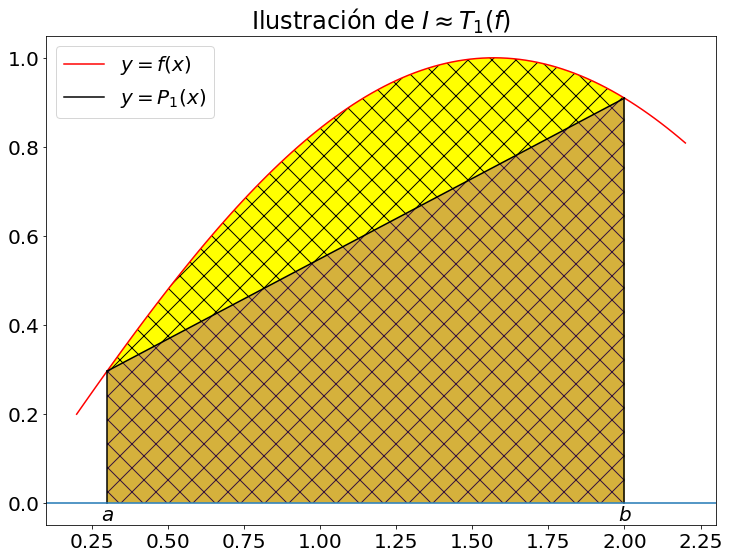

In [19]:
# plot

xr = np.linspace(0.2, 2.2, 100)
plt.plot(xr, np.sin(xr), "r", label="$y=f(x)$")
xr2_lim = [0.3, 2]
xr2 = np.linspace(*xr2_lim, 2)
xr2f = np.linspace(*xr2_lim)
plt.plot(xr2, np.sin(xr2), "k", label="$y=P_1(x)$")
#plt.plot([0.3] + list(xr2) + [2], [0] + list(np.sin(xr2)) + [0], label="$y=P_1(x)$")
plt.fill_between(xr2f, 0, np.sin(xr2f), facecolor='yellow', hatch="\/")
plt.fill_between(xr2, 0, np.sin(xr2), facecolor='#9030A060')
for x in xr2:
    plt.plot([x, x], [0, np.sin(x)], "k")
plt.axhline()
plt.title(r"Ilustración de $I \approx T_1(f)$")
plt.annotate("$a$", xy=(0.28, -0.04))
plt.annotate("$b$", xy=(1.98, -0.04))
plt.legend(); 

### Ejemplo

\begin{align}
\int_0^{\pi/2} \sin x \,\d x & \approx \frac{\pi}{4} [\sin 0 + \sin \frac{\pi}{2}]\\
  &= \frac{\pi}{4} \doteq 0.785398\\
\text{Error} &= 0.215\\  
\end{align}


## Mejorar la precisión

Para mejorar la aproximación al integral
$$
I = \int_a^b f(x) \,\d x
$$
tenemos dos opciones:

1. Usar interplación cuadratica
2. Usar sub-intervalos más pequeñas

Vamos usar la 2a opción
\begin{align}
I &= \int_a^c f(x) \,\d x + \int_c^b f(x) \,\d x, \qquad c = \frac{a + b}{2} \\
  &\approx \frac{c - a}{2} [f(a) + f(c)] + \frac{b - c}{2} [f(c) + f(b)] \\
  &= \frac{h}{2} [f(a) + 2f(c) + f(b)] \equiv T_2(f), \qquad h = \frac{b - a}{2}
\end{align}


### Ejemplo

\begin{align}
\int_0^{\pi/2} \sin x \,\d x & \approx \frac{\pi}{8} [\sin 0 + +2\sin \frac{\pi}{4} + \sin \frac{\pi}{2}]\\
  &\doteq 0.948059\\
\text{Error} &= 0.0519\\  
\end{align}


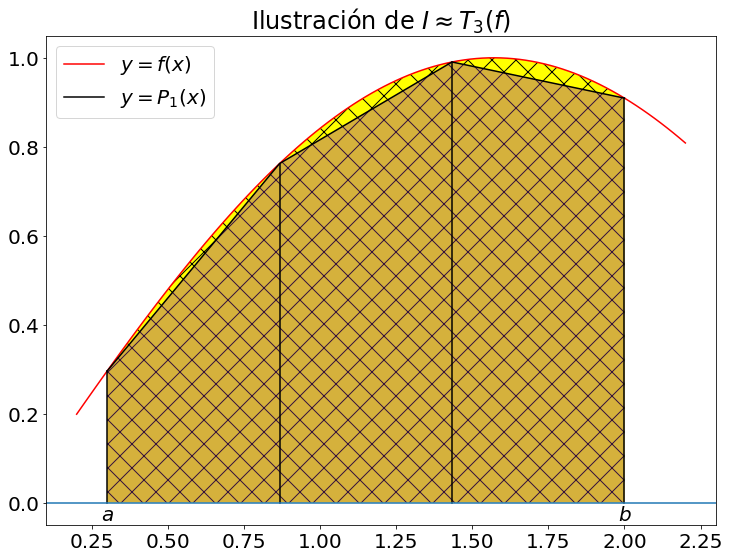

In [20]:
#
xr = np.linspace(0.2, 2.2, 100)
plt.plot(xr, np.sin(xr), "r", label="$y=f(x)$")
xr2_lim = [0.3, 2]
xr2 = np.linspace(*xr2_lim, 4)
xr2f = np.linspace(*xr2_lim)
plt.plot(xr2, np.sin(xr2), "k", label="$y=P_1(x)$")
plt.fill_between(xr2f, 0, np.sin(xr2f), facecolor='yellow', hatch="\/")
plt.fill_between(xr2, 0, np.sin(xr2), facecolor='#9030A060')
for x in xr2:
    plt.plot([x, x], [0, np.sin(x)], "k")
plt.axhline()
plt.title(r"Ilustración de $I \approx T_3(f)$")
plt.annotate("$a$", xy=(0.28, -0.04))
plt.annotate("$b$", xy=(1.98, -0.04))
plt.legend();

## Regla del trapezoide

Podemos continuar sub-dividiendo el intervalo $[a, b]$ en sub-intervalos más pequeños. En cada sub-intervalo aplicamos
$$
\int_\alpha^\beta f(x)\,\d x \approx \frac{\beta - \alpha}{2} [f(\alpha) + f(\beta)]
$$
Para un numero entero $n \geq 1$ definimos
$$
h = \frac{b - a}{n}, \qquad x_j = a + j\,h,\quad j=0, 1, \dots, n
$$
Nos da
\begin{align}
I &= \int_{x_0}^{x_n} f(x)\,\d x\\
  &= \int_{x_0}^{x_1} f(x)\,\d x + \int_{x_1}^{x_2} f(x)\,\d x + \dots + \int_{x_{n-1}}^{x_n} f(x)\,\d x
\end{align}
Usamos $[\alpha, \beta] = [x_0, x_1], [x_1, x_2], \dots, [x_{n-1}, x_n]$ con $h$ la longitud de los intervalos.

con
$$
\int_\alpha^\beta f(x)\,\d x \approx \frac{\beta - \alpha}{2} [f(\alpha) + f(\beta)]
$$
optenemos
\begin{align}
I \approx& \frac{h}{2}[f(x_0) + f(x_1)] + \frac{h}{2}[f(x_1) + f(x_2)] \\
  & + \dots \\
  & + \frac{h}{2}[f(x_{n-2}) + f(x_{n-1})] + \frac{h}{2}[f(x_{n-1}) + f(x_n)] \\
\end{align}
Se puede simplificar para obtener
\begin{align}
I &= h \left[ \frac{1}{2} f(a) + f(x_1) + \dots + f(x_{n-1}) + \frac{1}{2} f(b) \right]\\
  &\equiv T_n(f)
\end{align}
Esta regla se llama *regla trapezoide compuesta* o, simplemente, *regla trapezoide*.

### Ejemplo

Evaluamos 
$$
\int_0^{\pi/2} \sin x\,\d x
$$

In [21]:
def trapezoidal(f, rang, exact, log_n=8):
    T1 = (rang[1] - rang[0]) / 2 * (f(rang[0]) + f(rang[1]))
    err1 = exact - T1
    res = [[1, T1, err1, np.nan]]
    h = rang[1] - rang[0]
    n = 1
    for i in range(log_n):
        h /= 2
        Tn = T1 / 2
        for j in range(n):
            Tn += h * f(rang[0] + h + 2*j*h)
        n *= 2
        err_n = exact - Tn 
        res.append([n, Tn, err_n, err1 / err_n])
        err1 = err_n
        T1 = Tn
    return res

tabt = trapezoidal(np.sin, (0, np.pi/2), 1)

In [22]:
tabt = pd.DataFrame(tabt, columns=["$n$", "$T_n(f)$", "Error", "Ratio"]) 
tabt.style.format(dict(zip(tabt.columns, ["{:g}", "{:.9f}", "{:.2e}", lambda x: fltx(x, code="f", precision=2)])))

,$n$,$T_n(f)$,Error,Ratio
0,1,0.785398163,2.15e-01,
1,2,0.948059449,5.19e-02,$4.13$
2,4,0.987115801,1.29e-02,$4.03$
3,8,0.996785172,3.21e-03,$4.01$
4,16,0.999196680,8.03e-04,$4.00$
5,32,0.999799194,2.01e-04,$4.00$
6,64,0.999949800,5.02e-05,$4.00$
7,128,0.999987450,1.25e-05,$4.00$
8,256,0.999996863,3.14e-06,$4.00$


Notamos que el error baja asimptoticamente por un factor 4 en cada iteración. 

Duplicar $n$ en cada iteración nos permita re-usar los valores de $f(x)$ previamente calculados.

## Usando interpolación cuadratica

Para evaluar la integral 
$$
I = \int_a^b f(x)\,\d x
$$
usamos una aproximación cuadratica para $f(x)$. Interpolamos en los puntos $\{a, c, b\}$ con $c = 1/2 (a + b)$. Definimos $h = 1/2 (b - a)$. El polinomio interpolante es
\begin{align}
P_2(x) =& \frac{(x - c)(x - b)}{2h^2} f(a)+ \frac{(x - a)(x - b)}{-h^2} f(c)\\
&+ \frac{(x - a)(x - c)}{2h^2} f(b)\\
\end{align}
Nos da la aproximación
\begin{align}
\int_a^b f(x)\,\d x &\approx \int_a^b P_2(x)\,\d x\\
  &= \frac{h}{3} [f(a) + 4f(c) + f(b)] \equiv S_2(f)\\
\end{align}
Esta regla es la *regla de Simpson*.

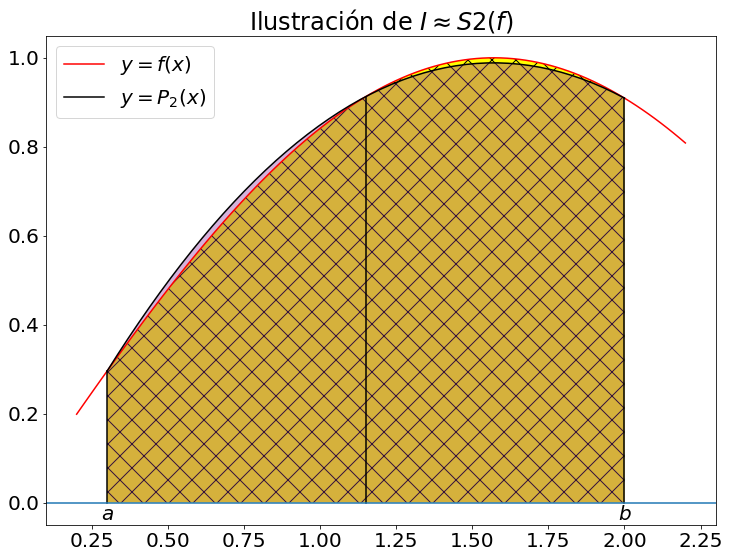

In [23]:
#
from scipy.interpolate import lagrange
xr = np.linspace(0.2, 2.2, 100)
plt.plot(xr, np.sin(xr), "r", label="$y=f(x)$")
xr2_lim = [0.3, 2]
xr2 = np.linspace(*xr2_lim, 3)
p2 = lagrange(xr2, np.sin(xr2))
xr2f = np.linspace(*xr2_lim)
plt.plot(xr2f, p2(xr2f), "k", label="$y=P_2(x)$")
plt.fill_between(xr2f, 0, np.sin(xr2f), facecolor='yellow', hatch="\/")
plt.fill_between(xr2f, 0, p2(xr2f), facecolor='#9030A060')
for x in xr2:
    plt.plot([x, x], [0, np.sin(x)], "k")
plt.axhline()
plt.title(r"Ilustración de $I \approx S2(f)$")
plt.annotate("$a$", xy=(0.28, -0.04))
plt.annotate("$b$", xy=(1.98, -0.04))
plt.legend();

### Ejemplo

\begin{align}
\int_0^{\pi/2} \sin x \,\d x & \approx \frac{\pi/2}{3} [\sin 0 + 4\sin\frac{\pi}{4} + \sin \frac{\pi}{2}]\\
  &\doteq 1.00227987749221\\
\text{Error} &= -0.00228\\  
\end{align}


## Regla de Simpson

En el caso de la regla de Simpson también es posible sub-dividir los intevalos para obtener una mejor aproximación a 
$
I = \int_a^b f(x) \,\d x
$.
La regla de Simpson está dada por
$$
\int_\alpha^\beta f(x)\,\d x \approx \frac{\delta}{3} [f(\alpha) + 4f(\gamma) + f(\beta)] , \qquad \gamma = \frac{\alpha + \beta}{2}
$$
y $\delta = \frac{1}{2} (\beta - \alpha)$.

Para $n$ un entero positivo definimos
$$
h = \frac{b - a}{n}, \qquad x_j = a + j \, h, \quad j=0, 1, \dots, n
$$
Con esto obtenemos
\begin{align}
I &= \int_{x_0}^{x_n} f(x)\,\d x\\
  &= \int_{x_0}^{x_2} f(x)\,\d x + \int_{x_2}^{x_4} f(x)\,\d x + \dots + \int_{x_{n-2}}^{x_n} f(x)\,\d x\\
\end{align}


Aplicamos
$$
\int_\alpha^\beta f(x)\,\d x \approx \frac{\delta}{3} [f(\alpha) + 4f(\gamma) + f(\beta)] , \qquad \gamma = \frac{\alpha + \beta}{2}
$$
a cada uno de los integrales con
$$
[\alpha, \beta] = [x_0, x_2], [x_2, x_4], \dots, [x_{n-2}, x_n]
$$
Siempre es $\frac{1}{2} (\beta - \alpha) = h$. Nos da
\begin{align}
I \approx& \frac{h}{3} [f(x_0) + 4 f(x_1) + f(x_2)]\\
  & + \frac{h}{3} [f(x_2) + 4 f(x_3) + f(x_4)]\\
  & + \dots \\
  & + \frac{h}{3} [f(x_{n-4}) + 4 f(x_{n-3}) + f(x_{n-2})]\\
  & + \frac{h}{3} [f(x_{n-2}) + 4 f(x_{n-1}) + f(x_n)]\\
\end{align}


Se puede simplificar para obtener
\begin{align}
\int_a^b f(x)\,\d x \approx{}& \frac{h}{3} \bigl[ f(x_0) + 4 f(x_1) \\
  & + 2f(x_2) + 4 f(x_3) + 2f(x_4)\\
  & + \dots + 2f(x_{n-2}) + 4f(x_{n-1}) + f(x_n) \bigr] \\
  {}\equiv{}& S_n(f)
\end{align}
Es la *regla compuesta de Simpson* o simplemente la *regla de Simpson*.

### Ejemplo

Evaluamos 
$
\int_0^{\pi/2} \sin x\,\d x
$

In [24]:
def simpson(f, rang, exact, log_n=9):
    h = (rang[1] - rang[0]) / 2
    s_tmp = 2 * f(rang[0]+h)
    S1 = h / 3 * (f(rang[0]) + 2*s_tmp + f(rang[1]))
    err1 = exact - S1
    res = [[1, S1, err1, np.nan]]
    n = 2
    for i in range(log_n-1):
        Sn = (S1 - h / 3 * s_tmp) / 2
        h /= 2
        s_tmp = 0
        for j in range(n):
            s_tmp += 2 * f(rang[0] + h + 2*j*h)
        Sn += 2 * h / 3 * s_tmp
        n *= 2
        err_n = exact - Sn 
        res.append([n, Sn, err_n, err1 / err_n])
        err1 = err_n
        S1 = Sn
    return res

tabs = simpson(np.sin, (0, np.pi/2), 1)

In [25]:
tabs = pd.DataFrame(tabs, columns=["$n$", "$S_n(f)$", "Error", "Ratio"]) 
tabs.style.format(dict(zip(tabs.columns, ["{:g}", "{:.14f}", "{:.2e}", lambda x: fltx(x, code="f", precision=2)])))

,$n$,$S_n(f)$,Error,Ratio
0,1,1.00227987749221,-2.28e-03,
1,4,1.00013458497419,-1.35e-04,$16.94$
2,8,1.00000829552397,-8.30e-06,$16.22$
3,16,1.00000051668471,-5.17e-07,$16.06$
4,32,1.00000003226500,-3.23e-08,$16.01$
5,64,1.00000000201613,-2.02e-09,$16.00$
6,128,1.00000000012600,-1.26e-10,$16.00$
7,256,1.00000000000787,-7.87e-12,$16.00$
8,512,1.00000000000049,-4.92e-13,$16.00$


Notamos que el error baja asimptoticamente por un factor de 16 en cada interación. 

### Comparación de la convergencia

In [26]:
tabt.loc[8:].style.format(dict(zip(tabs.columns, ["{:g}", "{:.14f}", "{:.2e}", lambda x: fltx(x, code="f", precision=2)])))

,$n$,$T_n(f)$,Error,Ratio
8,256,0.999997,3.14e-06,$4.00$


In [27]:
tabs.loc[2:3].style.format(dict(zip(tabs.columns, ["{:g}", "{:.14f}", "{:.2e}", lambda x: fltx(x, code="f", precision=2)])))

,$n$,$S_n(f)$,Error,Ratio
2,8,1.00000829552397,-8.30e-06,$16.22$
3,16,1.00000051668471,-5.17e-07,$16.06$


Es instructivo revisar las tablas para diferentes funciones y comparar los metodos de integración.

In [28]:
def pptab(tab):
    t = pd.DataFrame(tab, columns=["$n$", "$I_n(f)$", "Error", "Ratio"]) 
    t.style.format(dict(zip(t.columns, ["{:g}", "{:.14f}", "{:.2e}", lambda x: fltx(x, code="f", precision=2)])))
    return t

In [29]:
fx1 = lambda x: np.exp(-x**2)
ex1 = 0.74682413281234
pptab(trapezoidal(fx1, (0, 1), ex1)).style.format("{:.6g}")

,$n$,$I_n(f)$,Error,Ratio
0,1,0.68394,0.0628844,nan
1,2,0.73137,0.0154539,4.06917
2,4,0.742984,0.00384004,4.02441
3,8,0.745866,0.000958518,4.00622
4,16,0.746585,0.000239536,4.00156
5,32,0.746764,5.98782e-05,4.00039
6,64,0.746809,1.49692e-05,4.0001
7,128,0.74682,3.74227e-06,4.00002
8,256,0.746823,9.35566e-07,4.00001


In [30]:
pptab(simpson(fx1, (0, 1), ex1)).style.format("{:.6g}")

,$n$,$I_n(f)$,Error,Ratio
0,1,0.74718,-0.000356296,nan
1,4,0.746855,-3.1247e-05,11.4026
2,8,0.746826,-1.98772e-06,15.72
3,16,0.746824,-1.24623e-07,15.9498
4,32,0.746824,-7.79465e-09,15.9883
5,64,0.746824,-4.87332e-10,15.9945
6,128,0.746824,-3.05412e-11,15.9565
7,256,0.746824,-1.99063e-12,15.3425
8,512,0.746824,-2.05946e-13,9.66577


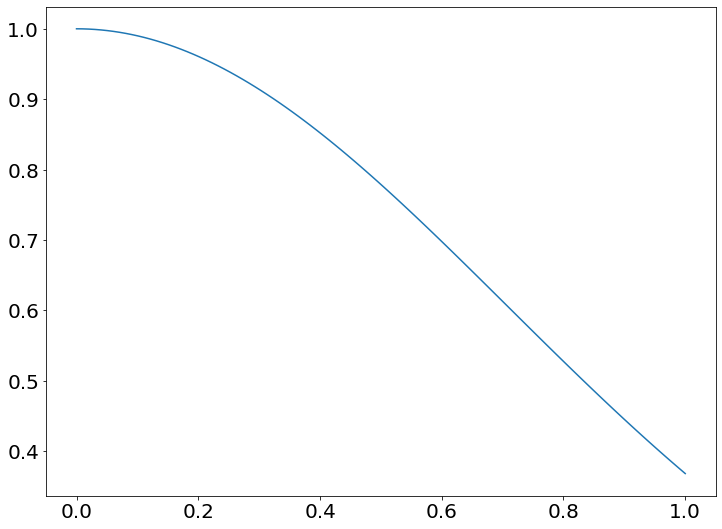

In [31]:
xrx1 = np.linspace(0, 1, 100)
plt.plot(xrx1, fx1(xrx1));

In [32]:
fx2 = lambda x: 1 / (1+x**2)
ex2 = np.arctan(4)
pptab(trapezoidal(fx2, (0, 4), ex2)).style.format("{:.6g}")

,$n$,$I_n(f)$,Error,Ratio
0,1,2.11765,-0.791829,nan
1,2,1.45882,-0.133006,5.95334
2,4,1.32941,-0.0035941,37.0067
3,8,1.32525,0.000564261,-6.36957
4,16,1.32567,0.000144082,3.91625
5,32,1.32578,3.6038e-05,3.99806
6,64,1.32581,9.01059e-06,3.99951
7,128,1.32582,2.25272e-06,3.99988
8,256,1.32582,5.63183e-07,3.99997


In [33]:
pptab(simpson(fx2, (0, 4), ex2)).style.format("{:.6g}")

,$n$,$I_n(f)$,Error,Ratio
0,1,1.23922,0.086602,nan
1,4,1.28627,0.0395432,2.19006
2,8,1.32387,0.00195038,20.2746
3,16,1.32581,4.02219e-06,484.905
4,32,1.32582,2.33365e-08,172.356
5,64,1.32582,1.4606e-09,15.9774
6,128,1.32582,9.13325e-11,15.9921
7,256,1.32582,5.70943e-12,15.9968
8,512,1.32582,3.5727e-13,15.9807


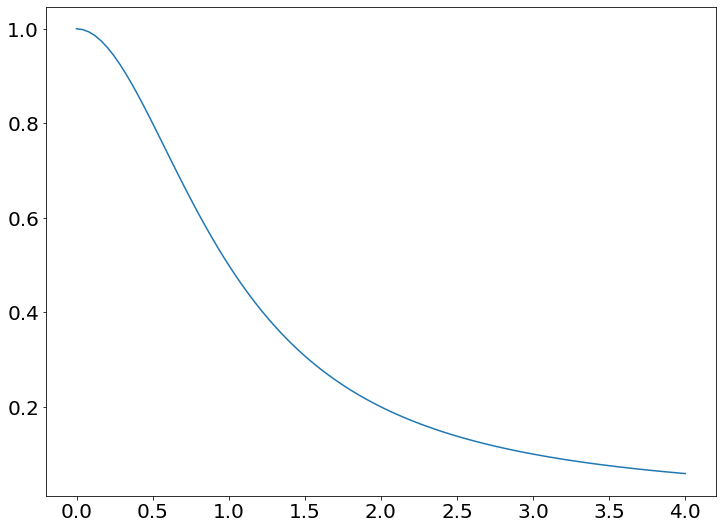

In [34]:
xrx2 = np.linspace(0, 4, 100)
plt.plot(xrx2, fx2(xrx2));

In [35]:
fx3 = lambda x: 1 / (2 + np.cos(x))
ex3 = 2 * np.pi / np.sqrt(3)
pptab(trapezoidal(fx3, (0, 2*np.pi), ex3)).style.format("{:.6g}")

<ipython-input-21-ff6a13a608d9>:14: RuntimeWarning: divide by zero encountered in double_scalars
  res.append([n, Tn, err_n, err1 / err_n])


,$n$,$I_n(f)$,Error,Ratio
0,1,2.0944,1.5332,nan
1,2,4.18879,-0.561191,-2.73205
2,4,3.66519,-0.0375927,14.9282
3,8,3.62779,-0.000192788,194.995
4,16,3.6276,-5.12258e-09,37635
5,32,3.6276,0,-inf
6,64,3.6276,-4.44089e-16,-0
7,128,3.6276,-8.88178e-16,0.5
8,256,3.6276,0,-inf


In [36]:
pptab(simpson(fx3, (0, 2*np.pi), ex3)).style.format("{:.6g}")

,$n$,$I_n(f)$,Error,Ratio
0,1,4.88692,-1.25932,nan
1,4,3.49066,0.13694,-9.19615
2,8,3.61532,0.0122738,11.1571
3,16,3.62753,6.42559e-05,191.015
4,32,3.6276,1.70753e-09,37631
5,64,3.6276,8.88178e-16,1.9225e+06
6,128,3.6276,8.88178e-16,1
7,256,3.6276,-8.88178e-16,-1
8,512,3.6276,-2.66454e-15,0.333333


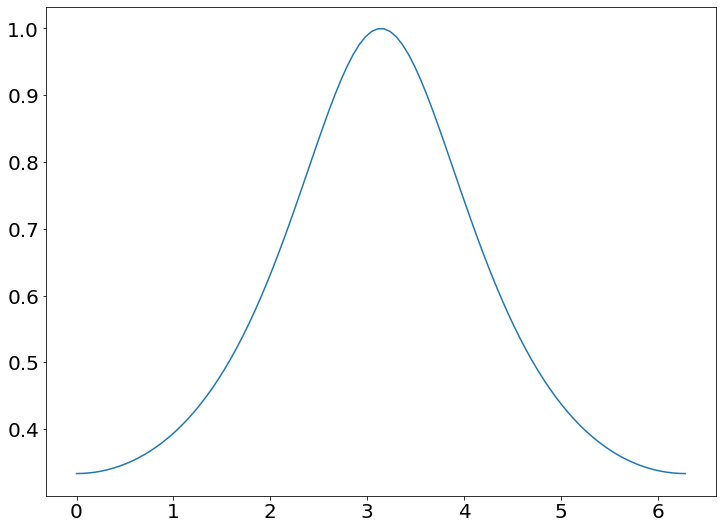

In [37]:
xrx3 = np.linspace(0, 2*np.pi, 100)
plt.plot(xrx3, fx3(xrx3));